# Import stuff

In [1]:
import numpy as np
import time, sys 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.circuit import Parameter
from copy import deepcopy
from math import pi
from qiskit.tools.visualization import plot_state_city
from qiskit.quantum_info import state_fidelity

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

from qiskit.providers.ibmq import IBMQ
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.monitor import job_monitor

# IBMQ Register/Device

In [2]:
ibmq_provider = IBMQ.load_account()

ibmq_simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
ibmq_device = ibmq_provider.get_backend('ibmq_essex')

backend_IBMQ = ibmq_provider.get_backend('ibmq_burlington')
properties = backend_IBMQ.properties()
noise_model = NoiseModel.from_backend(properties)
coupling_map = backend_IBMQ.configuration().coupling_map
basis_gates = noise_model.basis_gates

# Define stuff

In [3]:
theta = Parameter('theta')

#====================================================================================

def output_fidelity(F_in):
    """ Returns output fidelity of BBPSSW protocol.
    
    Keyword arguments:
    F_in -- input fidelity
    """
    F_out = (np.square(F_in) + np.square(1-F_in)/9) \
            / (np.square(F_in) + 2*F_in*(1-F_in)/3 + 5*np.square(1-F_in)/9)
 
    return F_out

#====================================================================================

phi_plus = np.array([1, 0, 0, 1])/np.sqrt(2)   # | Phi^+ >
phi_minus = np.array([1, 0, 0, -1])/np.sqrt(2) # | Phi^- >
psi_plus = np.array([0, 1, 1, 0])/np.sqrt(2)   # | Psi^+ >
psi_minus = np.array([0, 1, -1, 0])/np.sqrt(2) # | Psi^- >

#====================================================================================

def Werner_state(F):
    """Returns Werner state of fidelity F.
    
    Keyword arguments:
    F -- fidelity of Werner state, range [0, 1]
    """
    if F < 0 or F > 1:
        raise Exception('Fidelity must be between 0 and 1.')
    
    state = F*np.outer(psi_minus, psi_minus.conj().T) \
            + (1 - F)/3*(np.outer(phi_plus, phi_plus.conj().T) \
                        + np.outer(phi_minus, phi_minus.conj().T) \
                        + np.outer(psi_plus, psi_plus.conj().T))
    
    return state

#====================================================================================

def F_to_theta(F):
    """Returns the angle theta corresponding to an input fidelity F.
    
    Keyword arguments:
    F -- fidelity between 0 and 1
    """
    if F < 0 or F > 1:
        raise Exception('Fidelity must be between 0 and 1.')
    else:
        theta = np.arcsin(2*F - 1)
    
    return theta

#====================================================================================

def bilateral_rotation(circuit, qubits, rot_idx):
    """Adds a bilateral rotation to a quantum circuit.
    
    Keyword arguments:
    circuit --  quantum circuit to which the rotations are added
    qubits -- alist of qubits, each of which is rotated
    rot_idx -- integer that numbers the rotations from the set of all rotations, ranges from 0 to 11
    """
    for qubit in qubits:
        if rot_idx == 0:
            pass
        
        elif rot_idx == 1:
            circuit.rx(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        elif rot_idx == 2:
            circuit.ry(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            
        elif rot_idx == 3:
            circuit.rz(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            
        elif rot_idx == 4:
            circuit.rx(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            
        elif rot_idx == 5:
            circuit.ry(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            
        elif rot_idx == 6:
            circuit.rz(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        elif rot_idx == 7:
            circuit.ry(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        elif rot_idx == 8:
            circuit.rx(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            
        elif rot_idx == 9:
            circuit.ry(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            
        elif rot_idx == 10:
            circuit.rz(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        elif rot_idx == 11:
            circuit.ry(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        else:
            raise Exception('Input argument rot_idx has to be an integer between 0 and 11.')
            
#====================================================================================

def purification_shots(job_results):
    """ Keep counts for successful purifications and return corresponding result.
    
    Keyword arguments:
    job_results -- execution results
    
    Returns:
    conditional_results -- results without unsuccessful shots
    """
    # Copy original results
    conditional_results = deepcopy(job_results)
    
    for ii,_ in enumerate(job_results.results):
        counts = job_results.get_counts(ii)
        conditional_counts = {}
        
        # Keep counts of successful purifications
        for result, count in counts.items():
            target_measurement = result.split(' ')[0]
            control_measurement = result.split(' ')[1]

            if target_measurement in ('00', '11'):
                if control_measurement in conditional_counts:
                    conditional_counts[control_measurement] = conditional_counts[control_measurement] + count
                else:
                    conditional_counts[control_measurement] = count
        
        # Adapt the properties of conditional_results accordingly
        conditional_results.results[ii].data.counts \
            = conditional_results.results[ii].data.counts.from_dict(conditional_counts)
        conditional_results.results[ii].header.clbit_labels = conditional_results.results[ii].header.clbit_labels[0:2]
        conditional_results.results[ii].header.creg_sizes = [conditional_results.results[ii].header.creg_sizes[0]]
        conditional_results.results[ii].header.memory_slots = 2
            
    return conditional_results

#====================================================================================

def job_dictionary(circuits, job):
    """ Returns dictionary.
    
    Keyword arguments:
    circuits -- list of quantum circuits
    job -- execution job, should correspond to execution of keyword argument 'circuits'
    """
    job_dict = {}
    job_dict["circuits"] = circuits
    job_dict["job"] = job
    
    return job_dict

#====================================================================================

def rho_from_dict(job_dict, cond_tomo):
    """ Returns a reconstructed density matrix using quantum state tomography.
    
    Keyword arguments:
    job_dict -- dictionary containing execution job and corresponding quantum circuits
    cond_tomo -- boolean that indicates whether conditional tomography is being performed (cond_tomo=True)
    
    Returns:
    rho_fit -- reconstructed density matrix
    """
    if cond_tomo:
        # Conditional quantum state tomography
        conditional_results = purification_shots(job_dict["job"].result())
        rho_fit = StateTomographyFitter(conditional_results, job_dict["circuits"]).fit()
    else:
        # Regular quantum state tomography
        rho_fit = StateTomographyFitter(job_dict["job"].result(), job_dict["circuits"]).fit()
    
    return rho_fit

#====================================================================================

def execute_purification(F_in, index, backend, shots, noise_model=None, coupling_map=None, basis_gates=None):
    """ Execute entire BBPSSW protocol on a target backend.
    
    Keyword arguments:
    F_in -- input fidelity
    index -- integer between 0 and 11, defines bilateral rotation
    backend -- backend to execute circuits
    shots -- number of shots per execution
    noise_model -- noise model for simulation of real device (required for noisy simulation)
    coupling_map -- list that specifies the qubit couplings (required for noisy simulation)
    basis_gates -- set of basis gates on real device (required for noisy simulation)
    
    Returns:
    job_dict -- dictionary containing execution job and tomography circuits
    """
    # Create experiment circuit and corresponding tomography circuits
    experiment_circ = experiment_circuit(index)
    tomography_circs, ancilla_tomography_circs = conditional_tomography_circuits(experiment_circ)
    
    # Execute tomography circuits on simulator (w/ noise parameters) or real device (w/o noise parameters)
    if backend.configuration().simulator == True:
        job = execute(ancilla_tomography_circs, backend, shots=shots,
                      noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates,
                      parameter_binds=[{theta: F_to_theta(F_in)}])
    else:
        job = execute(ancilla_tomography_circs, backend, shots=shots,
                      parameter_binds=[{theta: F_to_theta(F_in)}])
    
    # Construct job dictionary
    job_dict = job_dictionary(tomography_circs, job)
        
    return job_dict

#====================================================================================

def experiment_circuit(index):
    """ Returns experiment circuit corresponding to an index.
    
    Keyword arguments:
    index -- integer between 0 and 11
    
    Returns:
    experiment_circ -- quantum circuit
    """
    if index < 0 or index > 11:
        raise Exception("Index for bilateral rotation exceeds range of possible values.")
        
    # Create twirl circuit from the bilateral rotations
    twirl_circ = QuantumCircuit(qr)
    bilateral_rotation(twirl_circ, control_qubits, index)
    bilateral_rotation(twirl_circ, target_qubits, index)
    
    experiment_circ = source_circ + twirl_circ + purification_circ
    
    return experiment_circ

#====================================================================================

def ancilla_circuit(quantum_circuit, qubits):
    """ Return an ancilla circuit that includes additional measurements.
    
    Keyword arguments:
    quantum_circuit -- single quantum circuit
    qubits -- list of qubits to be measured
    
    Returns:
    ancilla_circ -- ancilla quantum circuit including measurement of qubits
    """
    # Copy original circuit
    ancilla_circ = deepcopy(quantum_circuit)
    
    # Add classical register
    cr = ClassicalRegister(len(qubits))
    ancilla_circ.add_register(cr)
    
    # Measure qubits
    for i, qubit in enumerate(qubits):
        ancilla_circ.measure(qubit, cr[i])
    
    return ancilla_circ

#====================================================================================

def conditional_tomography_circuits(quantum_circuit):
    """ Returns all tomography circuits for conditional quantum state tomography. 
    
    Keyword arguments:
    quantum_circuit -- single quantum circuit
    
    Returns:
    tomography_circs -- tomography circuits for quantum circuit
    ancilla_tomography_circs -- ancilla tomography circuits with additional measurements on target qubits
    """
    # Create ancilla circuit
    ancilla_circ = ancilla_circuit(quantum_circuit, target_qubits)
    
    # Create tomography circuits
    tomography_circs = state_tomography_circuits(quantum_circuit, control_qubits)
    ancilla_tomography_circs = state_tomography_circuits(ancilla_circ, control_qubits)
    
    return tomography_circs, ancilla_tomography_circs

#====================================================================================

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)


# Circuit stuff

## Source circuit

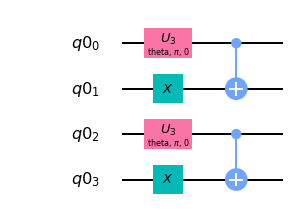

In [4]:
qr = QuantumRegister(4)
source_circ = QuantumCircuit(qr)

source_circ.x(qr[1]);
source_circ.u3(theta, pi, 0, qr[0]);
source_circ.cx(qr[0], qr[1]);
source_circ.x(qr[3])
source_circ.u3(theta, pi , 0, qr[2])
source_circ.cx(qr[2], qr[3]);

control_qubits = [qr[0], qr[1]]
target_qubits = [qr[2], qr[3]]

source_circ.draw(output='mpl')

## Twirl circuit

In [5]:
twirl_circ = QuantumCircuit(qr)

# Create a random integer between 0 and 11
random_idx = np.random.randint(12)

# Add a random bilateral rotation to the circuit, applied to qubits 0 and 1 (control qubits)
bilateral_rotation(twirl_circ, control_qubits, random_idx)

# Add a random bilateral rotation to the circuit, applied to qubits 2 and 3 (target qubits)
bilateral_rotation(twirl_circ, target_qubits, random_idx)

#twirl_circ.draw(output='mpl')

## Purification circuit

In [6]:
purification_circ = QuantumCircuit(qr)

# Implement a Pauli-Y gate on Alice's control qubit
purification_circ.y(control_qubits[0])

# Implement a Pauli-Y gate on Alice's target qubit
purification_circ.y(target_qubits[0]);

purification_circ.cx(control_qubits[0], target_qubits[0])
purification_circ.cx(control_qubits[1], target_qubits[1])
    
#purification_circ.draw(output='mpl')

## Final circuit

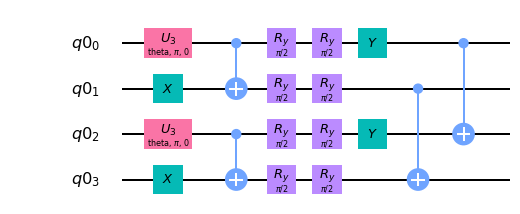

In [7]:
experiment_circ = source_circ + twirl_circ + purification_circ

experiment_circ.draw(output='mpl')

## Tomography circuit

In [8]:
tomography_circs = state_tomography_circuits(experiment_circ, control_qubits)

#tomography_circs[0].draw(output='mpl')

## Ancilla circuit

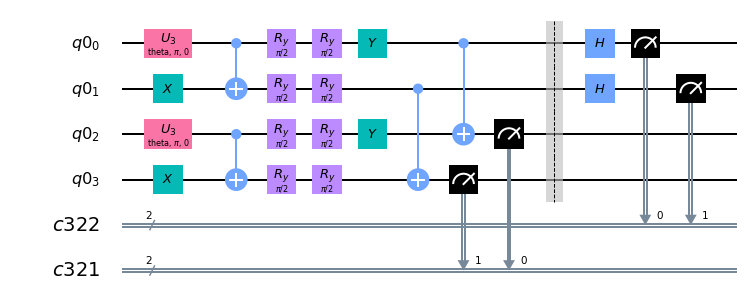

In [29]:
ancilla_circ = deepcopy(experiment_circ)
cr = ClassicalRegister(2)

ancilla_circ.add_register(cr)

ancilla_circ.measure(target_qubits[0], cr[0])
ancilla_circ.measure(target_qubits[1], cr[1])

ancilla_tomography_circs = state_tomography_circuits(ancilla_circ, control_qubits)

ancilla_tomography_circs[0].draw(output='mpl')

# Simulation

In [10]:
input_fidelities = [0.75]
N = 50



# Empty list for storing all output fidelities
output_fidelities = []

for jj, fidelity in enumerate(input_fidelities):
    fitted_states = []
    
    #update_progress(jj / len(input_fidelities))
    
    for ii in range(N):
        # Create circuits, execute circuits on simulator, reconstruct density matrix of control qubits
        random_idx = np.random.randint(12)
        job_dict = execute_purification(fidelity, random_idx, ibmq_simulator, shots=512)
        rho_fit = rho_from_dict(job_dict, cond_tomo=True)
        fitted_states.append(rho_fit)
        
        if ((ii+1)/10).is_integer() or ii == 0:
            print(str(ii+1) + "/" + str(N*len(input_fidelities)) + " simulation runs done. Out of " + str(jj+1) + "/" + str(len(input_fidelities)) + " input fidelities.")
    
    #update_progress(1)
        
    # Calculate average density matrix
    rho_average = sum(fitted_states)/N
    
    # Calculate fidelity towards Phi^+ and add fidelity to list
    output_fidelities.append(state_fidelity(rho_average, phi_plus))
    
    #print(str(jj+1) + "/" + str(len(input_fidelities)) + " simulation runs done.")
    

1/50 simulation runs done. Out of 1/1 input fidelities.
10/50 simulation runs done. Out of 1/1 input fidelities.
20/50 simulation runs done. Out of 1/1 input fidelities.
30/50 simulation runs done. Out of 1/1 input fidelities.
40/50 simulation runs done. Out of 1/1 input fidelities.
50/50 simulation runs done. Out of 1/1 input fidelities.


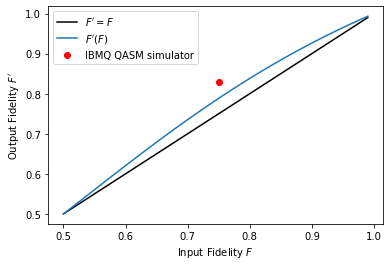

In [11]:
F_in = np.arange(0.5, 1.0, 0.01)
plt.plot(F_in, F_in, 'k', label = "$F' = F$")
plt.plot(F_in, output_fidelity(F_in), label = "$F'(F)$")
plt.plot(input_fidelities, output_fidelities, 'ro', label='IBMQ QASM simulator')
plt.legend()
plt.xlabel('Input Fidelity $F$')
plt.ylabel("Output Fidelity $F'$");


## With noise

In [12]:
input_fidelities_noise = [0.75]
N = 50



# Empty list for storing all output fidelities
output_fidelities_noise = []

for jj, fidelity in enumerate(input_fidelities_noise):
    fitted_states = []
    
    #update_progress(jj / len(input_fidelities_noise))
    
    for ii in range(N):
        # Create circuits, execute circuits on simulator, reconstruct density matrix of control qubits
        random_idx = np.random.randint(12)
        job_dict = execute_purification(fidelity, random_idx, ibmq_simulator, shots=512, 
                                        noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
        rho_fit = rho_from_dict(job_dict, cond_tomo=True)
        fitted_states.append(rho_fit)
        
        if ((ii+1)/10).is_integer() or ii == 0:
            print(str(ii+1) + "/" + str(N*len(input_fidelities_noise)) + " simulation runs done. Out of " + str(jj+1) + "/" + str(len(input_fidelities_noise)) + " input fidelities.")
                
        #print(str(jj+ii+1) + "/" + str(N*len(input_fidelities)) + " simulation runs done.")
    
    #update_progress(1)
        
    # Calculate average density matrix
    rho_average = sum(fitted_states)/N
    
    # Calculate fidelity towards Phi^+ and add fidelity to list
    output_fidelities_noise.append(state_fidelity(rho_average, phi_plus))
    
    #print(str(jj+1) + "/" + str(len(input_fidelities)) + " simulation runs done.")
    

1/50 simulation runs done. Out of 1/1 input fidelities.
10/50 simulation runs done. Out of 1/1 input fidelities.
20/50 simulation runs done. Out of 1/1 input fidelities.
30/50 simulation runs done. Out of 1/1 input fidelities.
40/50 simulation runs done. Out of 1/1 input fidelities.
50/50 simulation runs done. Out of 1/1 input fidelities.


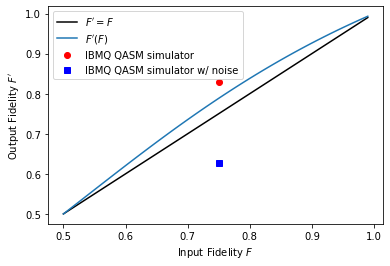

In [13]:
F_in = np.arange(0.5, 1.0, 0.01)
plt.plot(F_in, F_in, 'k', label = "$F' = F$")
plt.plot(F_in, output_fidelity(F_in), label = "$F'(F)$")
plt.plot(input_fidelities, output_fidelities, 'ro', label='IBMQ QASM simulator')
plt.plot(input_fidelities_noise, output_fidelities_noise, 'bs', label='IBMQ QASM simulator w/ noise')
plt.legend()
plt.xlabel('Input Fidelity $F$')
plt.ylabel("Output Fidelity $F'$");


## Device

In [21]:
input_fidelities_dev = [0.75]
N = 50



# Empty list for storing all output fidelities
output_fidelities_dev = []

for jj, fidelity in enumerate(input_fidelities_dev):
    fitted_states = []
    
    #update_progress(jj / len(input_fidelities))
    
    for ii in range(N):
        # Create circuits, execute circuits on simulator, reconstruct density matrix of control qubits
        random_idx = np.random.randint(12)
        job_dict = execute_purification(fidelity, random_idx, ibmq_device, shots=512)
        rho_fit = rho_from_dict(job_dict, cond_tomo=False)
        fitted_states.append(rho_fit)
        
        if ((ii+1)/10).is_integer() or ii == 0:
            print(str(ii+1) + "/" + str(N*len(input_fidelities_dev)) + " simulation runs done. Out of " + str(jj+1) + "/" + str(len(input_fidelities_dev)) + " input fidelities.")
    
    #update_progress(1)
        
    # Calculate average density matrix
    rho_average = sum(fitted_states)/N
    
    # Calculate fidelity towards Phi^+ and add fidelity to list
    output_fidelities_dev.append(state_fidelity(rho_average, phi_plus))
    
    #print(str(jj+1) + "/" + str(len(input_fidelities)) + " simulation runs done.")

IBMQJobFailureError: 'Unable to retrieve job result. Job has failed. Use job.error_message() to get more details.'

In [ ]:
F_in = np.arange(0.5, 1.0, 0.01)
plt.plot(F_in, F_in, 'k', label = "$F' = F$")
plt.plot(F_in, output_fidelity(F_in), label = "$F'(F)$")
plt.plot(input_fidelities, output_fidelities, 'ro', label='IBMQ QASM simulator')
plt.plot(input_fidelities_noise, output_fidelities_noise, 'bs', label='IBMQ QASM simulator w/ noise')
plt.plot(input_fidelities_dev, output_fidelities_dev, 'gt', label=backend_IBMQ.name())
plt.legend()
plt.xlabel('Input Fidelity $F$')
plt.ylabel("Output Fidelity $F'$");


In [22]:
job_dict["job"].error_message()

'Qubit measurement is followed by instructions. Error code: 7006.'